In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import h5py
import multiprocessing
from math import pi

from analysis.config import birds, h5_path_dict, pickle_dir
from analysis.ExpData import ExpData
from analysis.utils import popln_overlap, get_fr

In [ ]:
with open(pickle_dir / 'population_patterns_checks_long.p', 'rb') as f: 
    population_patterns = pickle.load(f)

In [ ]:
window_size = int(20*5)
fr_smoothing_window = int(20*0.25)
l2_normalization = True

In [ ]:
def plot_overlaps(all_overlaps, title):
    plt.figure()
    plt.hist(all_overlaps, bins=20, alpha=0.4, weights=np.ones(len(all_overlaps)) / len(all_overlaps))
    plt.title(title, fontsize=14)
    plt.ylabel("Proportion of Hops", fontsize=12)
    plt.xlabel("Population Overlap", fontsize=12)
    plt.xlim((0, 1))
    plt.ylim((0, 0.6))
    plt.show()
    print(len(all_overlaps))

In [21]:
def get_site_distance(a, b):
    dist = min(
        abs(a - b), 16 - abs(a-b)
        ) % 16
    return dist

# Cache v Retrieval

In [15]:
# Collect overlap matrices
all_overlap_matrices = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_hops = population_patterns[fil_string]['c_hops']
    r_hops = population_patterns[fil_string]['r_hops']
    noncrch_hops = population_patterns[fil_string]['noncrch_hops']
    hop_patterns = population_patterns[fil_string]['hop_patterns']

    for i, c_hop in enumerate(c_hops):
        c_site = exp_data.event_sites[exp_data.cache_event][i]
        cache_pattern_mat = hop_patterns[c_hop]
        for j, r_hop in enumerate(r_hops):
            if r_hop <= c_hop: continue
            r_site = exp_data.event_sites[exp_data.retriev_event][j]
            if r_site != c_site: continue
            retriev_pattern_mat = hop_patterns[r_hop]
            overlap_matrix = []
            for retriev_pattern in retriev_pattern_mat.T:
                cache_retriev_overlap = popln_overlap(
                    cache_pattern_mat, retriev_pattern
                    )
                overlap_matrix.append(cache_retriev_overlap)
            overlap_matrix = np.array(overlap_matrix)
            all_overlap_matrices.append(overlap_matrix)
            break
all_overlap_matrices = np.array(all_overlap_matrices)
all_overlap_matrices = np.nanmean(all_overlap_matrices, axis=0)

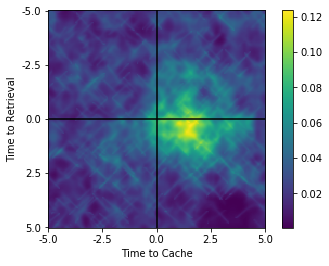

In [16]:
# Make heatmap
window_size = all_overlap_matrices.shape[0]
window_ticks = np.arange(0, window_size, window_size//4)
plt.imshow(all_overlap_matrices)
plt.yticks(window_ticks, (window_ticks-window_size//2)/20)
plt.xticks(window_ticks, (window_ticks-window_size//2)/20)
plt.axhline(window_size//2, color="black")
plt.axvline(window_size//2, color="black")
plt.ylabel("Time to Retrieval")
plt.xlabel("Time to Cache")
plt.colorbar()
plt.show()

# Cache v Retrieval at Faraway Sites

In [34]:
# Collect overlap matrices
all_overlap_matrices = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_hops = population_patterns[fil_string]['c_hops']
    r_hops = population_patterns[fil_string]['r_hops']
    noncrch_hops = population_patterns[fil_string]['noncrch_hops']
    hop_patterns = population_patterns[fil_string]['hop_patterns']

    for i, c_hop in enumerate(c_hops):
        c_site = exp_data.event_sites[exp_data.cache_event][i]
        cache_pattern_mat = hop_patterns[c_hop]
        for j, r_hop in enumerate(r_hops):
            if r_hop <= c_hop: continue
            r_site = exp_data.event_sites[exp_data.retriev_event][j]
            if get_site_distance(r_site, c_site) < 3: continue
            retriev_pattern_mat = hop_patterns[r_hop]
            overlap_matrix = []
            for retriev_pattern in retriev_pattern_mat.T:
                cache_retriev_overlap = popln_overlap(
                    cache_pattern_mat, retriev_pattern
                    )
                overlap_matrix.append(cache_retriev_overlap)
            overlap_matrix = np.array(overlap_matrix)
            all_overlap_matrices.append(overlap_matrix)
all_overlap_matrices = np.array(all_overlap_matrices)
all_overlap_matrices = np.nanmean(all_overlap_matrices, axis=0)

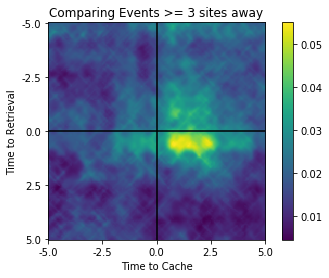

In [35]:
# Make heatmap
window_size = all_overlap_matrices.shape[0]
window_ticks = np.arange(0, window_size, window_size//4)
plt.imshow(all_overlap_matrices)
plt.yticks(window_ticks, (window_ticks-window_size//2)/20)
plt.xticks(window_ticks, (window_ticks-window_size//2)/20)
plt.axhline(window_size//2, color="black")
plt.axvline(window_size//2, color="black")
plt.ylabel("Time to Retrieval")
plt.xlabel("Time to Cache")
plt.title("Comparing Events >= 3 sites away")
plt.colorbar()
plt.show()

# Navigation v Navigation

In [28]:
window_size = int(20*5)

In [29]:
def get_reactiv_matrix(fil_string):
    overlap_matrices = np.zeros((window_size*2+1, window_size*2+1))
    count = 0
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_hops = population_patterns[fil_string]['c_hops']
    r_hops = population_patterns[fil_string]['r_hops']
    noncrch_hops = population_patterns[fil_string]['noncrch_hops']
    fr = population_patterns[fil_string]['fr']
    hop_patterns = population_patterns[fil_string]['hop_patterns']
    for i, noncrch1_hop in enumerate(noncrch_hops):
        noncrch1_site = exp_data.hop_end_wedges[noncrch1_hop]
        navig1_pattern_mat = hop_patterns[noncrch1_hop]
        for j, noncrch2_hop in enumerate(noncrch_hops):
            if j <= i: continue
            noncrch2_site = exp_data.hop_end_wedges[noncrch2_hop]
            if noncrch2_site != noncrch1_site: continue
            if exp_data.hop_start_wedges[noncrch1_hop] != exp_data.hop_start_wedges[noncrch2_hop]: continue
            navig2_pattern_mat = hop_patterns[noncrch2_hop]
            overlap_matrix = []
            for navig2_pattern in navig2_pattern_mat.T:
                navig1_navig2_overlap = popln_overlap(
                    navig1_pattern_mat, navig2_pattern
                    )
                overlap_matrix.append(navig1_navig2_overlap)
            overlap_matrix = np.array(overlap_matrix)
            overlap_matrix[np.isnan(overlap_matrix)] = 0
            overlap_matrices += overlap_matrix
            count += 1
    return overlap_matrices, count

In [30]:
# Run in parallel
PROCESSES = 5
all_overlap_matrices = np.zeros((window_size*2+1, window_size*2+1))
all_counts = 0
with multiprocessing.Pool(PROCESSES) as pool:
    params = [p for p in population_patterns.keys()]
    for overlap_matrices, count in pool.map(get_reactiv_matrix, params):
        all_overlap_matrices += overlap_matrices
        all_counts += count

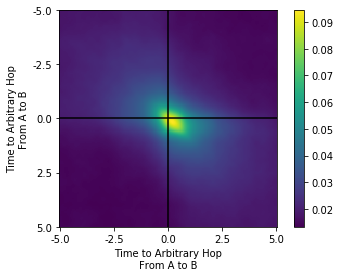

In [31]:
# Make heatmap
all_overlap_matrices /= all_counts
window_size = all_overlap_matrices.shape[0]
window_ticks = np.arange(0, window_size, window_size//4)
plt.imshow(all_overlap_matrices)
plt.yticks(window_ticks, (window_ticks-window_size//2)/20)
plt.xticks(window_ticks, (window_ticks-window_size//2)/20)
plt.axhline(window_size//2, color="black")
plt.axvline(window_size//2, color="black")
plt.ylabel("Time to Arbitrary Hop\nFrom A to B")
plt.xlabel("Time to Arbitrary Hop\nFrom A to B")
plt.colorbar()
plt.show()

# Cache v Navigation

In [17]:
# Collect overlap matrices
all_overlap_matrices = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_hops = population_patterns[fil_string]['c_hops']
    r_hops = population_patterns[fil_string]['r_hops']
    noncrch_hops = population_patterns[fil_string]['noncrch_hops']
    fr = population_patterns[fil_string]['fr']
    hop_patterns = population_patterns[fil_string]['hop_patterns']
    for i, c_hop in enumerate(c_hops):
        c_site = exp_data.event_sites[exp_data.cache_event][i]
        cache_pattern_mat = hop_patterns[c_hop]
        for j, noncrch_hop in enumerate(noncrch_hops):
            noncrch_site = exp_data.hop_end_wedges[noncrch_hop]
            if noncrch_site != c_site: continue
            if exp_data.hop_start_wedges[noncrch_hop] != exp_data.hop_start_wedges[c_hop]: continue
            navig_pattern_mat = hop_patterns[noncrch_hop]
            overlap_matrix = []
            for navig_pattern in navig_pattern_mat.T:
                cache_navig_overlap = popln_overlap(
                    cache_pattern_mat, navig_pattern
                    )
                overlap_matrix.append(cache_navig_overlap)
            overlap_matrix = np.array(overlap_matrix)
            all_overlap_matrices.append(overlap_matrix)
all_overlap_matrices = np.array(all_overlap_matrices)
all_overlap_matrices = np.nanmean(all_overlap_matrices, axis=0)

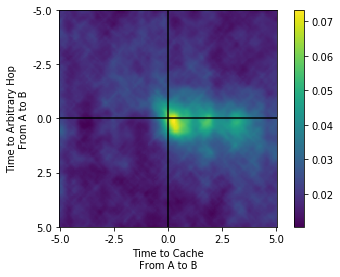

In [18]:
# Make heatmap
window_size = all_overlap_matrices.shape[0]
window_ticks = np.arange(0, window_size, window_size//4)
plt.imshow(all_overlap_matrices)
plt.yticks(window_ticks, (window_ticks-window_size//2)/20)
plt.xticks(window_ticks, (window_ticks-window_size//2)/20)
plt.axhline(window_size//2, color="black")
plt.axvline(window_size//2, color="black")
plt.ylabel("Time to Arbitrary Hop\nFrom A to B")
plt.xlabel("Time to Cache\nFrom A to B")
plt.colorbar()
plt.show()

# Retrieval v Navigation

In [19]:
# Collect overlap matrices
all_overlap_matrices = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_hops = population_patterns[fil_string]['c_hops']
    r_hops = population_patterns[fil_string]['r_hops']
    noncrch_hops = population_patterns[fil_string]['noncrch_hops']
    fr = population_patterns[fil_string]['fr']
    hop_patterns = population_patterns[fil_string]['hop_patterns']
    for i, r_hop in enumerate(r_hops):
        r_site = exp_data.event_sites[exp_data.retriev_event][i]
        retriev_pattern_mat = hop_patterns[r_hop]
        for j, noncrch_hop in enumerate(noncrch_hops):
            noncrch_site = exp_data.hop_end_wedges[noncrch_hop]
            if noncrch_site != r_site: continue
            if exp_data.hop_start_wedges[noncrch_hop] != exp_data.hop_start_wedges[r_hop]: continue
            navig_pattern_mat = hop_patterns[noncrch_hop]
            overlap_matrix = []
            for navig_pattern in navig_pattern_mat.T:
                cache_navig_overlap = popln_overlap(
                    retriev_pattern_mat, navig_pattern
                    )
                overlap_matrix.append(cache_navig_overlap)
            overlap_matrix = np.array(overlap_matrix)
            all_overlap_matrices.append(overlap_matrix)
all_overlap_matrices = np.array(all_overlap_matrices)
all_overlap_matrices = np.nanmean(all_overlap_matrices, axis=0)

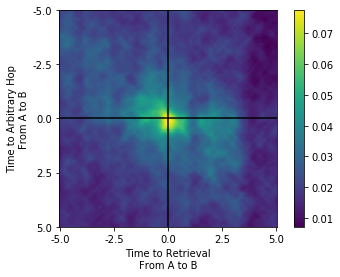

In [20]:
# Make heatmap
window_size = all_overlap_matrices.shape[0]
window_ticks = np.arange(0, window_size, window_size//4)
plt.imshow(all_overlap_matrices)
plt.yticks(window_ticks, (window_ticks-window_size//2)/20)
plt.xticks(window_ticks, (window_ticks-window_size//2)/20)
plt.axhline(window_size//2, color="black")
plt.axvline(window_size//2, color="black")
plt.ylabel("Time to Arbitrary Hop\nFrom A to B")
plt.xlabel("Time to Retrieval\nFrom A to B")
plt.colorbar()
plt.show()

# Cache Reactivation Pattern v Navigation
Heatmap will be aligned to maximal episode reactivation frame as opposed to the hop into a site

In [12]:
window = 40
fr_smoothing_window = int(20*0.25)
l2_normalization = True

In [13]:
# Collect reactivation times
all_reactiv_times = {} # Contains (c, r) pairs of frametimes
all_reactiv_sites = {}
all_overlaps = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_hops = population_patterns[fil_string]['c_hops']
    r_hops = population_patterns[fil_string]['r_hops']
    noncrch_hops = population_patterns[fil_string]['noncrch_hops']
    hop_patterns = population_patterns[fil_string]['hop_patterns']
    hop_times = population_patterns[fil_string]['hop_times']
    all_reactiv_times[fil_string] = []
    all_reactiv_sites[fil_string] = []

    for i, c_hop in enumerate(c_hops):
        c_site = exp_data.event_sites[exp_data.cache_event][i]
        cache_pattern_mat = hop_patterns[c_hop]
        for j, r_hop in enumerate(r_hops):
            if r_hop <= c_hop: continue
            r_site = exp_data.event_sites[exp_data.retriev_event][j]
            if r_site != c_site: continue
            retriev_pattern_mat = hop_patterns[r_hop]
            overlaps = []
            reactiv_times = []
            for r_frame, retriev_pattern in zip(hop_times[r_hop], retriev_pattern_mat.T):
                cache_retriev_overlap = popln_overlap(
                    cache_pattern_mat, retriev_pattern
                    )
                max_val = np.nanmax(cache_retriev_overlap)
                if not np.isnan(max_val):
                    overlaps.append(max_val)
                    c_frame = hop_times[c_hop][np.nanargmax(cache_retriev_overlap)]
                    reactiv_times.append([c_frame, r_frame])
            if len(overlaps) > 0:
                max_val = np.nanmax(overlaps)
                max_idx = np.nanargmax(overlaps)
                all_reactiv_times[fil_string].append(reactiv_times[max_idx])
                all_reactiv_sites[fil_string].append(c_site)
                all_overlaps.append(max_val)
            break

In [ ]:
# Calculate overlap aligned to reactivation times
all_max_overlaps = []
all_overlap_matrices = np.zeros((window*2+1, window*2+1))
matrix_counts = np.zeros(all_overlap_matrices.shape)
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    _, _, noncrch_hops = exp_data.get_cr_hops()
    reactiv_times = all_reactiv_times[fil_string]
    c_frames = np.array([
        np.arange(t[0] - window, t[0] + window + 1) for t in reactiv_times
        ])
    fr = get_fr(exp_data.spikes, fr_smoothing_window)
    if l2_normalization:
        scaling = np.square(np.linalg.norm(fr, axis=1))
        fr /= scaling[:, None]
    cache_indices = np.argwhere(exp_data.cache_event).squeeze()
    for cache_index, c_frame in zip(cache_indices, c_frames):
        c_site = exp_data.event_sites[cache_index]
        cache_pattern_mat = fr[:, c_frame]
        for noncrch_hop in noncrch_hops:
            if exp_data.hop_end_wedges[noncrch_hop] != c_site: continue
            noncrch_enter = exp_data.hops[noncrch_hop]
            noncrch_frame = np.arange(
                noncrch_enter - window, noncrch_enter + window + 1
                )
            if (noncrch_frame[0] < 0) or (noncrch_frame[-1] >= exp_data.num_frames):
                continue
            noncrch_pattern_mat = fr[:, noncrch_frame]
            overlap_matrix = []
            max_overlaps = []
            for noncrch_pattern in noncrch_pattern_mat.T:
                noncrch_overlap = popln_overlap(
                    cache_pattern_mat, noncrch_pattern
                    )
                overlap_matrix.append(noncrch_overlap)
                max_val = np.nanmax(noncrch_overlap)
                if not np.isnan(max_val):
                    max_overlaps.append(max_val)
            overlap_matrix = np.array(overlap_matrix)
            valid_indices = np.logical_not(np.isnan(overlap_matrix))
            all_overlap_matrices[valid_indices] += overlap_matrix[valid_indices]
            matrix_counts[valid_indices] += 1
            if len(max_overlaps) > 0:
                all_max_overlaps.append(np.nanmax(max_overlaps))
all_overlap_matrices = np.divide(all_overlap_matrices, matrix_counts)

In [ ]:
# Plot heatmap
window_size = all_overlap_matrices.shape[0]
window_ticks = np.arange(0, window_size, window_size//4)
plt.imshow(all_overlap_matrices)
plt.yticks(window_ticks, (window_ticks-window_size//2)/20)
plt.xticks(window_ticks, (window_ticks-window_size//2)/20)
plt.axhline(window_size//2, color="black")
plt.axvline(window_size//2, color="black")
plt.ylabel("Time to Navigation")
plt.xlabel("Time to Cache Memory")
plt.colorbar()
plt.show()

In [ ]:
plot_overlaps(all_max_overlaps, "Cache vs Navigation")